# KMeans Clustering with Fairlets
## A balanced approach to clustering
Unsupervised learning comes in a number of forms. One of the most popular approaches to correlating unlabeled data is through the process of clustering. Clustering attempts to unearth hidden patterns in data using a measure of similarity between the data points - often the Euclidean distance metric. Intuitively, clustering attempts to group data points that are "close" together according to the chosen metric.

### Fairness issues with clustering
Clustering is useful in a number of practices, from exploratory data analysis to defining predictive labels. However, clusters often produce concerning results, and can be biased by a "protected" class with respect to a subset of samples. This "protected" class can take many forms, and some examples include gender or race. The protected class may be correlated with other features and induce bias in the final clustering, so simply removing the protected class from consideration (a naive approach) doesn't avoid the problem (there are often surrogates for gender or race in these datasets, like income, which reflect a long history of societal inequity).

### Framing the problem
To address the imposed bias of the protected class, we can enforce something a "balance," ensuring in some way that the final clustering does not violate the doctrine of "disparate impact." The definition of disparate impact comes from powerful legal precedents, and states plainly that models or regulation can "adversely affect one group of people of a protected characteristic more than another, even though rules applied...are formally neutral (E.g. Griggs v. Duke Power Co. (1977))." In this case, "balancing" a clustering attempts to ensure that a model does favor one group in a protected class over another by ensuring a specific distribution of cluster members in the final model.

### Proposed methodologies for balanced clustering construction
Chierichetti et al. demonstrate a methodology for constructing a balanced clustering in their 2017 NeurIps paper ["Fair clustering through fairlets."](https://arxiv.org/pdf/1802.05733) by introducing the notion of "Fairlets" (fair subsets) and formulating the balancing problem as a Minimum Cost Flow graph. Schmidt et al. extended this work in their 2019 paper ["Fair Coresets and Streaming Algorithms for Fair k-Means Clustering"](http://arxiv.org/abs/1812.10854) and demonstrated how the work of Chierichetti et al. can be made scalable, and used for a k-means clustering algorithm.

Below we demonstrate our implementation of Fair KMeans clustering with fairlets, replicating the results from Chierichetti et al.'s original paper.

1. [Load the Data](#Load-the-data)
2. [Balanced and Unbalanced Clusterings](#Balanced-and-Unbalanced-Clusterings)
3. [Results](#Results)

## Load the Data
From the original paper, we load the "Bank" (Moro et. al, 2014) and "Census/Adult" (Kohavi, 1996) datasets.

We subsample the datasets to make the MCF problem tractable. (Note the opportunity for further work to increase scalability.)

In [1]:
from load_data import load_data
import time

def create_dsets(seed=None):
    if not seed:
        seed = int(time.time() / 10000)
    # Download data from UCI, and subsample to n samples as per the paper
    loaded = load_data([('bank', 200), ('adult', 200)], seed)

    # Create adult with features specified in paper
    adult = loaded['adult']['data'][['age','fnlwgt','education-num','capital-gain','hours-per-week','sex']]

    # Create bank with features specified in paper
    # For the bank dataset, we need to include divorcees as also being single, to create
    # a binary marital status
    bank = loaded['bank']['data'][['age','job','marital','balance']]
    bank.loc[(bank['marital'] == 0) | (bank['marital'] == 2), 'marital'] = 0

    # Two dsets
    # Denote name, data, protected_class, and column indices tuple (for visualization)
    dsets = [('bank', bank, 'marital', (0, 3)), ('adult', adult, 'sex',(0, 4))]
    return dsets

dsets = create_dsets()

/home/lurosenb/anaconda3/envs/fairk/lib/python3.6/site-packages/ipykernel_launcher.py:24: DtypeWarning: Columns (0,5,9,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.


Memory consumed by bank:28800
Memory consumed by adult:25600


/home/lurosenb/anaconda3/envs/fairk/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/lurosenb/anaconda3/envs/fairk/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Balanced and Unbalanced Clusterings
Here we actually create two models for each cluster size (from 3 clusters to n_clusters=10) - the first model is a traditional KMeans clustering from sklearn, while the second is our Fair_KMeans implementation that performs the fairlet decomposition (described in the paper) and labels the points accordingly.

Furthermore, we calculate the balance and cost of the standard model and the fair model. Our results match the paper: the Fair_KMeans clustering preserves the desired minimum balance of clusters (in this case, t_prime=1/2 for the protected class, or equal distribution), although there can be a significant cost to doing this (as quantified by sum of max point distances with clusters).

In [2]:
from sklearn.cluster import KMeans
from fairlearn.reductions import FairletKMeans
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

def balance(s, p_class):
    l_b = len(s[s[p_class] == 0]) 
    l_r = len(s[s[p_class] == 1]) 
    if l_b == 0 or l_r == 0:
        return 0
    br = l_b / l_r
    rb = l_r / l_b
    return min(br,rb)

def calculate_model_balances(kmeans_model, dset, protected_class):
    # Calculate balance for each center and take the average
    cluster_balances = []
    labels = np.unique(kmeans_model.labels_)
    for center in labels:
        indices = np.where(kmeans_model.labels_ == center)[0]
        subset = dset.iloc[indices]

        b = balance(subset, protected_class)

        cluster_balances.append(b)
    return cluster_balances

def run_experiment(data_sets, reruns, visualize_clusters=False):
    # Number of clusters range
    n_clusters = 10

    # Cluster models
    dset_balance_list = []
    dset_balance_list_fair = []
    
    for n, dset, protected_class, (ind1, ind2) in data_sets:
        print(dset)
        cluster_models_balance_k = []
        cluster_models_balance_k_fair = []

        cluster_models_cost_k = []
        cluster_models_cost_k_fair = []

        clusters = []
        for i in range(3, n_clusters):
            # Number of clusters
            k = i + 1
            clusters.append(k)

            # Unfair clustering
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=600).fit(dset)

            # Note that according to the definition of a fair clustering,
            # the minimum balance of any one cluster in a d_set is the
            # value we care about
            cluster_models_balance_k.append(min(calculate_model_balances(kmeans, dset, protected_class)))
            cluster_models_cost_k.append(kmeans.inertia_)

            try:
                kmeans_fair = FairletKMeans(n_clusters=k, random_state=42, t_prime=2, thresh=20, protected_class=protected_class).fit(dset)
                cluster_models_balance_k_fair.append(min(calculate_model_balances(kmeans_fair, dset, protected_class)))
                cluster_models_cost_k_fair.append(kmeans_fair.fairlet_cost_)
            except nx.NetworkXUnfeasible:
                print('Could not find solution with this subsample of ' + n + ' dataset. Recreating datasets. Will rerun at most ' + str(reruns) + ' more times.')
                if reruns > 0:
                    data_sets = create_dsets()
                    reruns = reruns - 1
                    run_experiment(data_sets, reruns, visualize_clusters)
                else:
                    raise "Could not find solution. Try decreasing k clusters, or increasing sample size. Sorry!"
            
            if visualize_clusters:
                plt.figure(figsize=(8, 6))
                plt.scatter(dset.to_numpy()[:,ind1], dset.to_numpy()[:,ind2], c=kmeans.labels_.astype(float)) 

                plt.figure(figsize=(8, 6))
                plt.scatter(dset.to_numpy()[:,ind1], dset.to_numpy()[:,ind2], c=kmeans_fair.labels_.astype(float))


        dset_balance_list.append((n, cluster_models_balance_k, clusters, cluster_models_cost_k))
        dset_balance_list_fair.append((n, cluster_models_balance_k_fair, clusters, cluster_models_cost_k_fair))
    return dset_balance_list, dset_balance_list_fair

dset_balance_list, dset_balance_list_fair = run_experiment(dsets, 5)

       age  job  marital  balance
26720   40    1        1     3765
19862   60    9        0     2934
26807   36    7        0       54
67      60    5        1      100
16013   32    4        0        0
...    ...  ...      ...      ...
28397   33    4        0     1590
39321   40    4        1      198
18634   51    6        1      833
22901   48    0        1       44
15209   36    4        1      708

[200 rows x 4 columns]
Fairlets and corresponding Centroids identified in 1.341324806213379
Fairlets and corresponding Centroids identified in 1.3621642589569092
Fairlets and corresponding Centroids identified in 1.3474748134613037
Fairlets and corresponding Centroids identified in 1.3730359077453613
Fairlets and corresponding Centroids identified in 1.368605136871338
Fairlets and corresponding Centroids identified in 1.3962783813476562
Fairlets and corresponding Centroids identified in 1.3633580207824707
       age  fnlwgt  education-num  capital-gain  hours-per-week  sex
28443   18 

## Plot balance and Cost
Here we plot the balance/cost across clusterings (from 3 to n_clusters).

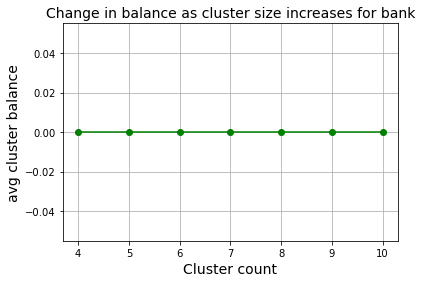

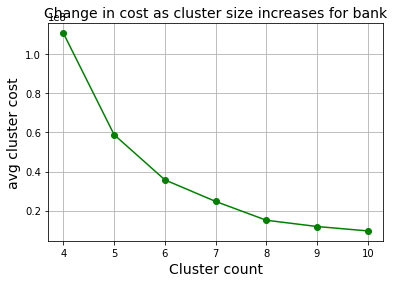

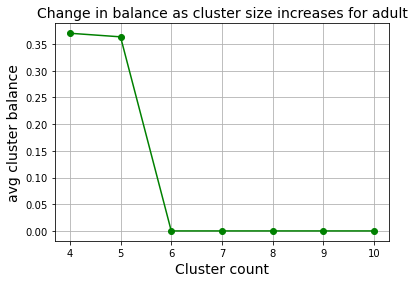

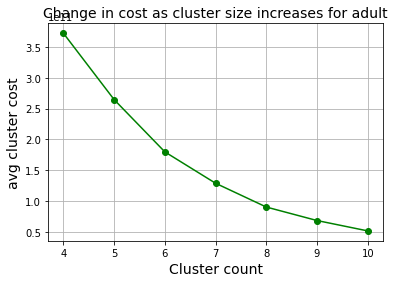

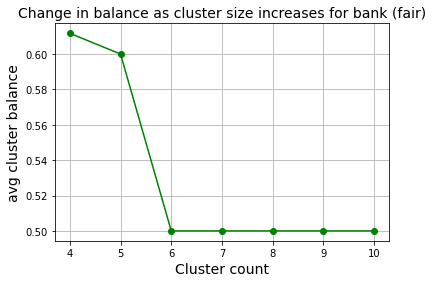

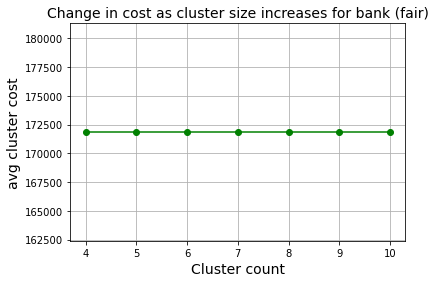

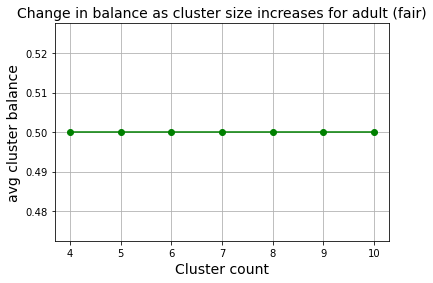

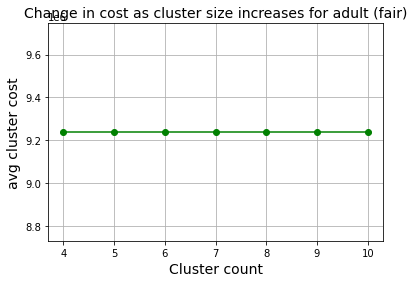

In [3]:
import matplotlib.pyplot as plt

def plot_balance(d, clusters, n, g):
    plt.plot(clusters, d, color='green', marker='o')
    plt.title('Change in ' + g + ' as cluster size increases for ' + n, fontsize=14)
    plt.xlabel('Cluster count', fontsize=14)
    plt.ylabel('avg cluster ' + g, fontsize=14)
    plt.grid(True)
    plt.show()
    
for n, d, clust, cost in dset_balance_list:
    plot_balance(d,clust,n,'balance')
    plot_balance(cost,clust,n,'cost')
    
for n, d, clust, cost in dset_balance_list_fair:
    plot_balance(d,clust,n+' (fair)','balance')
    plot_balance(cost,clust,n+' (fair)','cost')